In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scripts.downloader import fetch_all_polls

In [12]:
all_polls = fetch_all_polls(cleanup=True, refresh=False)
all_polls.to_csv('poll_database/poll_database.csv', index=False)
all_polls.to_excel('poll_database/poll_database.xlsx', index=False)
all_polls.to_html('poll_database/poll_database.html', index=False)
all_polls.to_json('poll_database/poll_database.json', index=False, orient='table')

In [13]:
display_columns = ['date_concluded', 'pollster', 'conservative', 'labour', 'liberal_democrat', 'lead']

In [14]:
print('Last 20 Polls')
all_polls[display_columns][0:20]

Last 20 Polls


,date_concluded,pollster,conservative,labour,liberal_democrat,lead
0,2021-12-23,Opinium,32.0,39.0,11.0,lab+7.0
1,2021-12-22,Survation,35.0,41.0,9.0,lab+6.0
2,2021-12-21,FocalData,34.0,41.0,9.0,lab+7.0
3,2021-12-21,FocalData,32.0,40.0,10.0,lab+8.0
4,2021-12-20,Redfield & Wilton Strategies,31.0,39.0,13.0,lab+8.0
5,2021-12-20,YouGov,30.0,36.0,12.0,lab+6.0
6,2021-12-19,Savanta ComRes,32.0,37.0,13.0,lab+5.0
7,2021-12-16,Savanta ComRes,34.0,38.0,10.0,lab+4.0
8,2021-12-15,Find Out Now,30.0,38.0,10.0,lab+8.0
9,2021-12-15,YouGov,32.0,37.0,10.0,lab+5.0


In [15]:
all_polls.query("pollster == 'YouGov' and conservative <31")[display_columns]

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
5,2021-12-20,YouGov,30.0,36.0,12.0,lab+6.0
537,2019-09-20,YouGov,30.0,23.0,22.0,con+7.0
565,2019-08-14,YouGov,30.0,21.0,20.0,con+9.0
578,2019-07-24,YouGov,25.0,19.0,23.0,con+2.0
579,2019-07-17,YouGov,25.0,21.0,20.0,con+4.0
...,...,...,...,...,...,...
2213,2013-02-19,YouGov,29.0,44.0,11.0,lab+15.0
2231,2013-02-04,YouGov,30.0,45.0,11.0,lab+15.0
2272,2012-12-19,YouGov,30.0,43.0,11.0,lab+13.0
2289,2012-12-04,YouGov,30.0,44.0,11.0,lab+14.0


In [16]:
most_recent_date = all_polls.iloc[0].date_concluded
one_year_polls = all_polls[
    all_polls['date_concluded'] >= (most_recent_date + relativedelta(months=-12)).replace(day=1)].copy()

In [17]:
pollsters_latest = pd.DataFrame()
for pollster in one_year_polls.pollster.unique():
    pollster_data = one_year_polls.query(f'pollster == "{pollster}"')
    latest_poll = pollster_data.iloc[0]
    pollsters_latest = pollsters_latest.append(latest_poll)

In [18]:
top_five = {'Ipsos MORI': 100,
            'Opinium': 79,
            'YouGov': 77,
            'Kantar Public': 69,
            'Number Cruncher Politics': 61,
            'Survation': 59,
            'Panelbase': 57,
            'Deltapoll': 46,
            'BMG Research': 44,
            'FocalData': 39,
            'ICM Research': 35,
            'Savanta ComRes': 34,
            'Find Out Now': 34,
            'Redfield & Wilton Strategies': 34,
            }

top_two = {'Ipsos MORI': 100,
           'Survation': 85,
           'Kantar Public': 85,
           'Panelbase': 74,
           'Number Cruncher Politics': 71,
           'Opinium': 71,
           'YouGov': 67,
           'Deltapoll': 50,
           'FocalData': 42,
           'BMG Research': 39,
           'Savanta ComRes': 29,
           'ICM Research': 27,
           'Find Out Now': 34,
           'Redfield & Wilton Strategies': 34,
           }

In [19]:
def get_recency_weight(date_concluded, current_date):
    days_since_poll = (current_date - date_concluded).days
    if days_since_poll < 8:
        return 100
    if days_since_poll > 90:
        return 0
    if days_since_poll > 30:
        return 5 - ((days_since_poll - 30)/60)*5
    if days_since_poll > 15:
        return 70 - ((days_since_poll - 15)/15)*65
    else:
        return 100 - ((days_since_poll - 7)/8)*30


def get_pollster_weight(pollster):
    top_five_score = top_five[pollster]
    top_two_score = top_two[pollster]
    pollster_w = (3*top_two_score + 2*top_five_score + 100)/6
    return pollster_w


In [20]:
from scripts.constants import major_parties

In [21]:
pollsters_latest['recency_weight'] = pollsters_latest['date_concluded'].apply(get_recency_weight,
                                                                              current_date=most_recent_date)
pollsters_latest['pollster_weight'] = pollsters_latest['pollster'].apply(get_pollster_weight)
pollsters_latest['poll_weight'] = pollsters_latest['pollster_weight']*(pollsters_latest['recency_weight']/100)

In [22]:
current_average = pd.DataFrame(columns=major_parties + ['lead'], index=['Polling Average'])
lead_party = ''
max_vote_share = 0
second_vote_share = 0
for party in major_parties:
    party_vote_share = pollsters_latest[party].dot(pollsters_latest['poll_weight'])/pollsters_latest[
        'poll_weight'].sum()
    if party_vote_share > max_vote_share:
        second_vote_share = max_vote_share
        max_vote_share = party_vote_share
        lead_party = party
    else:
        if party_vote_share > second_vote_share:
            second_vote_share = party_vote_share
    current_average.loc['Polling Average', party] = f'{party_vote_share:.1f}%'
current_average.loc['Polling Average', 'lead'] = f'{lead_party:.3s}+{max_vote_share - second_vote_share:.1f}%'


In [23]:
one_year_polls['poll_month'] = one_year_polls['date_concluded'].apply(lambda x: x.replace(day=1))

In [24]:
pollster_monthly_summary = one_year_polls.groupby(['poll_month', 'pollster'])[major_parties].agg(['mean', 'count'])
pollster_monthly_summary.columns = [x if i == 0 else f'count{major_parties.index(x)}' for x in major_parties for i in
                                    range(0, 2)]
pollster_monthly_summary.drop(columns=[f'count{major_parties.index(x)}' for x in major_parties][1:], inplace=True)
pollster_monthly_summary.rename(columns={"count0": "count"}, inplace=True)

In [25]:
agg_info = {x: ['mean'] for x in major_parties}
agg_info['count'] = ['count', 'sum']
monthly_summary = pollster_monthly_summary.reset_index().groupby(['poll_month']).agg(agg_info)
monthly_summary.columns = major_parties + ['pollster_count', 'poll_count']

In [26]:
display(pollsters_latest.sort_values(by='poll_weight', ascending=False)[display_columns])
display(current_average)
display(monthly_summary.iloc[:0:-1])

,date_concluded,pollster,conservative,labour,liberal_democrat,lead
1,2021-12-22,Survation,35.0,41.0,9.0,lab+6.0
0,2021-12-23,Opinium,32.0,39.0,11.0,lab+7.0
17,2021-12-10,Ipsos MORI,34.0,39.0,11.0,lab+5.0
5,2021-12-20,YouGov,30.0,36.0,12.0,lab+6.0
11,2021-12-13,Kantar Public,34.0,38.0,11.0,lab+4.0
2,2021-12-21,FocalData,34.0,41.0,9.0,lab+7.0
4,2021-12-20,Redfield & Wilton Strategies,31.0,39.0,13.0,lab+8.0
8,2021-12-15,Find Out Now,30.0,38.0,10.0,lab+8.0
6,2021-12-19,Savanta ComRes,32.0,37.0,13.0,lab+5.0
24,2021-12-04,Deltapoll,37.0,38.0,10.0,lab+1.0


,conservative,labour,liberal_democrat,lead
Polling Average,32.9%,38.7%,10.8%,lab+5.8%


,conservative,labour,liberal_democrat,pollster_count,poll_count
poll_month,,,,,
2021-12-01,33.758333,38.400000,10.100000,10,28
2021-11-01,37.066667,36.575000,9.250000,10,23
2021-10-01,39.268750,34.645833,8.289583,8,20
2021-09-01,39.843333,34.331667,9.376667,10,23
2021-08-01,40.016667,33.316667,10.400000,6,18
2021-07-01,41.787037,33.601852,9.444444,9,21
2021-06-01,43.477778,33.455556,7.566667,9,24
2021-05-01,43.468750,32.812500,8.062500,8,21
2021-04-01,41.921212,35.186364,7.448485,11,25


<AxesSubplot:xlabel='poll_month'>

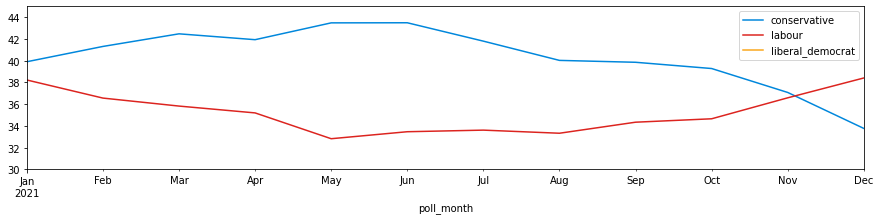

In [30]:
from scripts.constants import party_colors

monthly_summary[['conservative', 'labour','liberal_democrat']][1:].plot(
    figsize=[15, 3],
    ylim=[30, 45],
    color=party_colors,

)